In [2]:
# requirements

# pip install pandas numpy pillow torch torchvision transformers scikit-learn timeout-decorator peft accelerate datasets bitsandbytes bert-score rouge-score rapidfuzz sentence-transformers evaluate

In [4]:
import os
import gc
from pathlib import Path
import pandas as pd
import numpy as np
from PIL import Image
import torch
from transformers import (
    BlipProcessor,
    BlipForQuestionAnswering,
    AutoProcessor,
    Trainer,
    TrainingArguments
)
from peft import PeftModel, PeftConfig, LoraConfig, get_peft_model
from tqdm import tqdm
from timeout_decorator import timeout, TimeoutError
from accelerate import Accelerator
from transformers.data.data_collator import default_data_collator
from sklearn.metrics import (
    accuracy_score,
    precision_recall_fscore_support,
    f1_score
)
from bert_score import BERTScorer, score
from rouge_score import rouge_scorer
from rapidfuzz.distance import Levenshtein
from sentence_transformers import SentenceTransformer, util
import evaluate
from PIL import Image
import matplotlib.pyplot as plt

## Dataset

In [7]:
train_df = pd.read_csv('/kaggle/input/dataset/train_datapoints.csv')
val_df = pd.read_csv('/kaggle/input/dataset/val_datapoints.csv')

print(f"training dataset with {len(train_df)} entries")
print(f"validation dataset with {len(val_df)} entries")

Training dataset with 56000 entries
Validation dataset with 14000 entries


In [9]:
train_df["full_image_path"] = train_df["full_image_path"].apply(lambda p: p.replace("\\", "/"))
train_df["full_image_path"] = train_df["full_image_path"].apply(lambda p: str(Path("/kaggle/input") / p))

val_df["full_image_path"] = val_df["full_image_path"].apply(lambda p: p.replace("\\", "/"))
val_df["full_image_path"] = val_df["full_image_path"].apply(lambda p: str(Path("/kaggle/input") / p))


In [10]:
train_df

,image_id,full_image_path,question,answer
0,619aXYWDlfL,/kaggle/input/abo-images-small/images/small/82...,what color is the ring?,white
1,71oqXnBtfUL,/kaggle/input/abo-images-small/images/small/eb...,what color is background?,pink
2,618rflVTnTL,/kaggle/input/abo-images-small/images/small/b9...,how many stripes are visible?,three
3,61oFSxHBFLL,/kaggle/input/abo-images-small/images/small/68...,what is the product?,case
4,717qOUqAkFL,/kaggle/input/abo-images-small/images/small/a9...,what is the shape surrounding the image?,oval
...,...,...,...,...
55995,71Bz+4y4LRL,/kaggle/input/abo-images-small/images/small/7a...,what is the main color?,blue
55996,61PSTG1tCuL,/kaggle/input/abo-images-small/images/small/42...,how many buttons are visible?,one
55997,61+OVTFVWRL,/kaggle/input/abo-images-small/images/small/03...,what shape is the sensor?,square
55998,61eO4Ya4B+L,/kaggle/input/abo-images-small/images/small/59...,how many cameras are visible?,three


## Checking Image path

Sample image to test image path


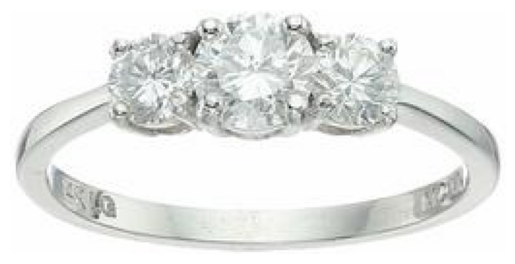

In [6]:

# === Display first image to verify path works ===
print("Sample image to test image path")
img_path = train_df['full_image_path'].iloc[0]
img = Image.open(img_path).convert("RGB")


plt.imshow(img)
plt.axis('off')  
plt.show()

## This Custom Dataset class loads image question answer pairs and encodes them with processor


In [6]:
#VQA dataset

class VQADataset(torch.utils.data.Dataset):
    def __init__(self, df, processor):
        self.df = df
        self.processor = processor

    def __len__(self):
        return len(self.df)

    @timeout(10)  
    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        image_path = row['full_image_path']
        try:
            if not os.path.exists(image_path):
                print(f"Image not found: {image_path}")
                image = Image.new("RGB", (224, 224), (0, 0, 0))  # Fallback image
            else:
                image = Image.open(image_path).convert("RGB")
        except Exception as e:
            print(f"Error loading image {image_path}: {e}")
            image = Image.new("RGB", (224, 224), (0, 0, 0))  
        
        question = row['question']
        answer = row['answer']

        # Process image and question with attention mask
        encoding = self.processor(
            images=image,
            text=question,
            padding="max_length",
            max_length=128,
            truncation=True,
            return_tensors="pt",
            return_attention_mask=True
        )
        
        # Tokenize answer as labels with fixed length
        labels = self.processor.tokenizer(
            answer,
            padding="max_length",
            truncation=True,
            max_length=32,
            return_tensors="pt"
        )["input_ids"]

        # Remove batch dimension from tensors
        encoding = {k: v.squeeze(0) for k, v in encoding.items()}
        encoding["labels"] = labels.squeeze(0)

        return encoding

In [7]:
#Initializing the model
accelerator = Accelerator()
processor = BlipProcessor.from_pretrained("Salesforce/blip-vqa-base", use_fast=True)
model = BlipForQuestionAnswering.from_pretrained("Salesforce/blip-vqa-base")

preprocessor_config.json:   0%|          | 0.00/445 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/592 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/711k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/4.56k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.54G [00:00<?, ?B/s]

In [8]:
train_dataset = VQADataset(train_df, processor)
val_dataset = VQADataset(val_df, processor)

## LoRa Configuration 

In [9]:
lora_config = LoraConfig(
    r=32,
    lora_alpha=32,
    target_modules=["query", "value"],
    lora_dropout=0.1,
    bias="none"
)
model = get_peft_model(model, lora_config)
print("LoRA applied to the model")

# Prepare model with Accelerator
model = accelerator.prepare(model)

LoRA applied to the model


## Setting up training arguments and initialize Trainer for fine-tuning the VQA model


In [10]:
training_args = TrainingArguments(
    output_dir="/kaggle/working/results",
    run_name="blip_vqa_lora_finetune",
    num_train_epochs=3,
    per_device_train_batch_size=4,
    gradient_accumulation_steps=4,
    learning_rate=5e-5,
    weight_decay=0.01,
    logging_dir='/kaggle/working/logs',
    logging_steps=10,
    save_strategy="epoch",
    fp16=True,
    remove_unused_columns=False,
    report_to="none"
)

# Create Trainer instance with default data collator
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    data_collator=default_data_collator,
)

No label_names provided for model class `PeftModel`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.


In [11]:
if torch.cuda.is_available():
    print("GPU Memory Usage Before Training:")
    print(torch.cuda.memory_summary())

GPU Memory Usage Before Training:
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |   1488 MiB |   1488 MiB |   1488 MiB |      0 B   |
|       from large pool |   1468 MiB |   1468 MiB |   1468 MiB |      0 B   |
|       from small pool |     19 MiB |     19 MiB |     19 MiB |      0 B   |
|---------------------------------------------------------------------------|
| Active memory         |   1488 MiB |   1488 MiB |   1488 MiB |      0 B   |
|       from large pool |   14

In [12]:
trainer.train()

We strongly recommend passing in an `attention_mask` since your input_ids may be padded. See https://huggingface.co/docs/transformers/troubleshooting#incorrect-output-when-padding-tokens-arent-masked.
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Step,Training Loss
10,10.217200
20,10.015300
30,9.816500
40,9.633100
50,9.492300
60,9.366800
70,9.213400
80,9.085700
90,8.959000
100,8.873700


/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


TrainOutput(global_step=7500, training_loss=8.150330848185222, metrics={'train_runtime': 24414.4801, 'train_samples_per_second': 9.83, 'train_steps_per_second': 0.307, 'total_flos': 6.296953473652531e+16, 'train_loss': 8.150330848185222, 'epoch': 2.9991000899910008})

In [13]:
# Evaluate the model on the test dataset
eval_results = trainer.evaluate()
print("Evaluation Results:", eval_results)

# Save the fine-tuned model 
trainer.save_model("/kaggle/working/fine_tuned_blip_vqa_lora")
print("Model saved to '/kaggle/working/fine_tuned_blip_vqa_lora'")

/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Evaluation Results: {'eval_runtime': 1103.2264, 'eval_samples_per_second': 18.13, 'eval_steps_per_second': 1.134, 'epoch': 2.9991000899910008}
Model saved to '/kaggle/working/fine_tuned_blip_vqa_lora'


In [14]:
skipped_entries = []

# Function to predict answer with timeout
@timeout(10)  # Set timeout to 10 seconds
def predict_answer(image_path, question):
    try:
        if not os.path.exists(image_path):
            print(f"Image not found: {image_path}")
            return ""
        image = Image.open(image_path).convert("RGB")

        # Prepare inputs for BLIP VQA
        inputs = processor(images=image, text=question, return_tensors="pt", padding=True).to(device)

        # Use generate for inference
        with torch.no_grad():
            output_ids = model.generate(**inputs, max_new_tokens=20)
        predicted_answer = processor.decode(output_ids[0], skip_special_tokens=True).strip()

        # Extract one-word answer (post-process if needed)
        predicted_answer = predicted_answer.split()[-1] if predicted_answer else ""

        del inputs, output_ids
        gc.collect()
        torch.cuda.empty_cache()
        return predicted_answer
    except Exception as e:
        print(f"Error processing {image_path}: {e}")
        return ""

### Set to Eval mode

In [15]:
accelerator = Accelerator()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
processor = BlipProcessor.from_pretrained("Salesforce/blip-vqa-base",use_fast = True)
base_model = BlipForQuestionAnswering.from_pretrained("Salesforce/blip-vqa-base")

model = PeftModel.from_pretrained(base_model, "/kaggle/working/fine_tuned_blip_vqa_lora/")
model = accelerator.prepare(model)
model.eval()

PeftModel(
  (base_model): LoraModel(
    (model): BlipForQuestionAnswering(
      (vision_model): BlipVisionModel(
        (embeddings): BlipVisionEmbeddings(
          (patch_embedding): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
        )
        (encoder): BlipEncoder(
          (layers): ModuleList(
            (0-11): 12 x BlipEncoderLayer(
              (self_attn): BlipAttention(
                (dropout): Dropout(p=0.0, inplace=False)
                (qkv): Linear(in_features=768, out_features=2304, bias=True)
                (projection): Linear(in_features=768, out_features=768, bias=True)
              )
              (layer_norm1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
              (mlp): BlipMLP(
                (activation_fn): GELUActivation()
                (fc1): Linear(in_features=768, out_features=3072, bias=True)
                (fc2): Linear(in_features=3072, out_features=768, bias=True)
              )
              (layer_norm2): Lay

In [16]:
import os
os.makedirs("/kaggle/working/resultCSV", exist_ok=True)

## We save prediction csv here and detailed evaluation using this csv is done in Final_Evaluation notebook

In [17]:

start_idx = 0
pred_path = '/kaggle/working/resultCSV/predictions.csv'
if os.path.exists(pred_path):
    try:
        existing = pd.read_csv(pred_path)
        if not existing.empty:
            start_idx = len(existing)
            print(f"Resuming from index {start_idx}")
        else:
            print(f"Prediction file {pred_path} is empty, starting from index 0")
    except pd.errors.EmptyDataError:
        print(f"Prediction file {pred_path} is empty, starting from index 0")
else:
    print(f"No existing prediction file found, starting from index 0")

#Lists to store predictions and ground truth
df = test_df
predictions = []
ground_truths = df["answer"].tolist()
y_true = []
y_pred = []
results = []
all_preds = []
# Predict answers for each row
for idx, row in tqdm(df.reset_index(drop=True).iterrows(), total=len(df), desc="Processing"):
    if idx < start_idx:
        continue  # Skip already processed rows
    full_image_path = row["full_image_path"]
    question = row["question"]
    try:
        predicted = predict_answer(full_image_path, question)
    except TimeoutError:
        print(f"Timeout processing row {idx}: {full_image_path}")
        skipped_entries.append({"row": idx, "full_image_path": full_image_path, "question": question})
        predicted = ""
    predictions.append(predicted)

    y_true.append(str(ground_truths[idx]).lower())
    y_pred.append(str(predicted).lower())
    
    all_preds.append(str(predicted).lower())
    
    results.append({
        "img_path": full_image_path,
        "question": question,
        "true_answer": str(ground_truths[idx]).lower(),
        "predicted_answer": str(predicted).lower()
    })
    if (idx + 1) % 1000 == 0 or (idx + 1) == len(df):
        # Convert to DataFrame
        chunk_df = pd.DataFrame(results)

        # Save predictions
        if not os.path.exists(pred_path):
            chunk_df.to_csv(pred_path, mode='w', index=False, header=True)
        else:
            chunk_df.to_csv(pred_path, mode='a', index=False, header=False)

        print(f"Checkpoint saved at index {idx + 1}")
        # Reset for next chunk
        results = []
        y_true = []
        y_pred = []

No existing prediction file found, starting from index 0


Processing:   5%|▍         | 1000/20001 [08:34<2:41:57,  1.96it/s]

Checkpoint saved at index 1000


Processing:  10%|▉         | 2000/20001 [17:17<2:38:49,  1.89it/s]

Checkpoint saved at index 2000


Processing:  15%|█▍        | 3000/20001 [25:55<2:24:45,  1.96it/s]

Checkpoint saved at index 3000


Processing:  20%|█▉        | 4000/20001 [34:29<2:17:15,  1.94it/s]

Checkpoint saved at index 4000


Processing:  25%|██▍       | 5000/20001 [43:02<2:08:06,  1.95it/s]

Checkpoint saved at index 5000


Processing:  30%|██▉       | 6000/20001 [51:35<2:00:56,  1.93it/s]

Checkpoint saved at index 6000


Processing:  35%|███▍      | 7000/20001 [1:00:10<1:49:51,  1.97it/s]

Checkpoint saved at index 7000


Processing:  40%|███▉      | 8000/20001 [1:08:42<1:42:21,  1.95it/s]

Checkpoint saved at index 8000


Processing:  45%|████▍     | 9000/20001 [1:17:17<1:34:17,  1.94it/s]

Checkpoint saved at index 9000


Processing:  50%|████▉     | 10000/20001 [1:25:55<1:26:41,  1.92it/s]

Checkpoint saved at index 10000


Processing:  55%|█████▍    | 11000/20001 [1:34:34<1:17:40,  1.93it/s]

Checkpoint saved at index 11000


Processing:  60%|█████▉    | 12000/20001 [1:43:18<1:09:51,  1.91it/s]

Checkpoint saved at index 12000


Processing:  65%|██████▍   | 13000/20001 [1:52:05<1:02:15,  1.87it/s]

Checkpoint saved at index 13000


Processing:  70%|██████▉   | 14000/20001 [2:00:51<53:21,  1.87it/s]

Checkpoint saved at index 14000


Processing:  75%|███████▍  | 15000/20001 [2:09:34<43:26,  1.92it/s]

Checkpoint saved at index 15000


Processing:  80%|███████▉  | 16000/20001 [2:18:16<35:39,  1.87it/s]

Checkpoint saved at index 16000


Processing:  85%|████████▍ | 17000/20001 [2:26:59<26:01,  1.92it/s]

Checkpoint saved at index 17000


Processing:  90%|████████▉ | 18000/20001 [2:35:42<17:38,  1.89it/s]

Checkpoint saved at index 18000


Processing:  95%|█████████▍| 19000/20001 [2:44:27<08:50,  1.89it/s]

Checkpoint saved at index 19000


Processing: 100%|█████████▉| 20000/20001 [2:53:13<00:00,  1.90it/s]

Checkpoint saved at index 20000


Processing: 100%|██████████| 20001/20001 [2:53:14<00:00,  1.92it/s]

Checkpoint saved at index 20001


In [18]:
# Normalize case
preds = pd.read_csv('/kaggle/working/resultCSV/predictions.csv')
preds = preds.dropna()
# preds = preds.iloc[1:].reset_index(drop=True)
all_preds_BLIP = preds['predicted_answer'].tolist()
all_actuals_BLIP = preds['true_answer'].tolist()

In [19]:

preds_l = [p.lower() for p in all_preds_BLIP if isinstance(p, str)]
refs_l = [r.lower() for r in all_actuals_BLIP if isinstance(r, str)]


# Compute exact-match binary metrics
y_pred_bin = [int(p == r) for p, r in zip(preds_l, refs_l)]
y_true_bin = [1] * len(all_actuals_BLIP)

acc = accuracy_score(y_true_bin, y_pred_bin)
prec, rec, f1, _ = precision_recall_fscore_support(
    y_true_bin, y_pred_bin, average="binary", zero_division=0
)

# Print metrics
print(f"Exact-match Accuracy: {acc:.3f}")
print(f"Exact-match Precision: {prec:.3f}")
print(f"Exact-match Recall:    {rec:.3f}")
print(f"Exact-match F1:        {f1:.3f}\n")

Exact-match Accuracy: 0.625
Exact-match Precision: 1.000
Exact-match Recall:    0.625
Exact-match F1:        0.769



In [20]:
from bert_score import score

P, R, F1 = score(preds_l, refs_l, lang="en", verbose=True, rescale_with_baseline = True)
print(f"BERTScore - Precision: {P.mean():.4f}, Recall: {R.mean():.4f}, F1: {F1.mean():.4f}")

tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/482 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.42G [00:00<?, ?B/s]

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


calculating scores...
computing bert embedding.


  0%|          | 0/30 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/313 [00:00<?, ?it/s]

done in 4.89 seconds, 4089.42 sentences/sec
BERTScore - Precision: 0.9246, Recall: 0.9050, F1: 0.9134


In [21]:
scorer = rouge_scorer.RougeScorer(['rouge1', 'rougeL'], use_stemmer=True)
rouge1_scores = []
rougeL_scores = []

for pred, ref in zip(preds_l, refs_l):
    scores = scorer.score(ref, pred)
    rouge1_scores.append(scores["rouge1"].fmeasure)
    rougeL_scores.append(scores["rougeL"].fmeasure)

print(f"ROUGE Scores:")
print(f"ROUGE-1 F1: {np.mean(rouge1_scores):.4f}")
print(f"ROUGE-L F1: {np.mean(rougeL_scores):.4f}")

ROUGE Scores:
ROUGE-1 F1: 0.6375
ROUGE-L F1: 0.6375


In [22]:
# 5. Sentence Embedding Cosine Similarity (memory-efficient pairwise)
model = SentenceTransformer('all-MiniLM-L6-v2')
pred_embeds = model.encode(preds_l, convert_to_tensor=True, device='cuda')
ref_embeds = model.encode(refs_l, convert_to_tensor=True, device='cuda')

cos_sims = [
    util.cos_sim(pred_embeds[i], ref_embeds[i]).item()
    for i in range(len(preds_l))
]

print(f"Sentence-BERT Cosine Similarity:")
print(f"Average Cosine Similarity: {np.mean(cos_sims):.4f}")


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.5k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Batches:   0%|          | 0/625 [00:00<?, ?it/s]

Batches:   0%|          | 0/625 [00:00<?, ?it/s]

Sentence-BERT Cosine Similarity:
Average Cosine Similarity: 0.8169
